<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S54_diffdrive_perception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q -U gtbook


Note: you may need to restart the kernel to use updated packages.


In [2]:
from gtbook import diffdrive
import PIL
import numpy as np

import torch
DEVICE = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

import matplotlib.pyplot as plt
%matplotlib inline


# Computer Vision 101

> Convolution is the workhorse for much of computer vision.

<img src="Figures5/S54-Two-wheeled_Toy_Robot-03.jpg" alt="Splash image with steampunk differential drive robot thinking" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

No book about robotics is complete without mentioning computer vision and introducing some of its main ideas, which we do in this section. However, computer vision is a large subject and it is not our intention to summarize the entire field and its many recent developments in this section. Rather, we give a broad overview of the ideas, and our treatment is necessarily light and superficial.

A very good resource for a deeper dive into the concepts introduced here and in Section 5.6 is the book [Dive into Deep Learning](https://d2l.ai/), which is structured as a completely executable set of jupyter notebooks. We encourage you to check it out.

## Linear Filtering

> Filtering can be applied to spatial, as well as temporal, data.

In the previous chapter, we developed the Bayesian filter, and applied it to temporal data streams.
Here, we extend the idea of filtering to spatial data, such as images, instead of time sequences.

Recall the image from the previous section:

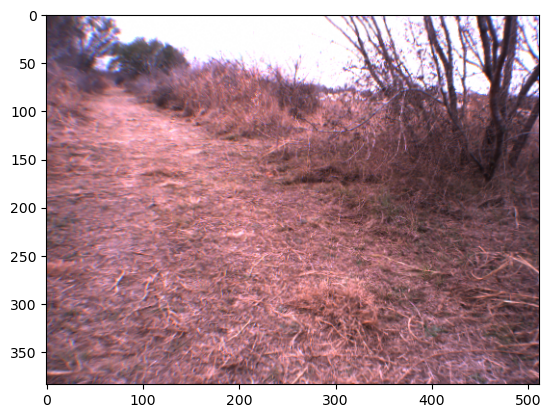

In [3]:
image_name = "LL_color_1201754063.387872.bmp"
lagr_image = diffdrive.read_image(image_name) # locally: PIL.Image.open(image_name)
plt.imshow(lagr_image);


First, to explain linear filtering operations, we will convert the image to grayscale:

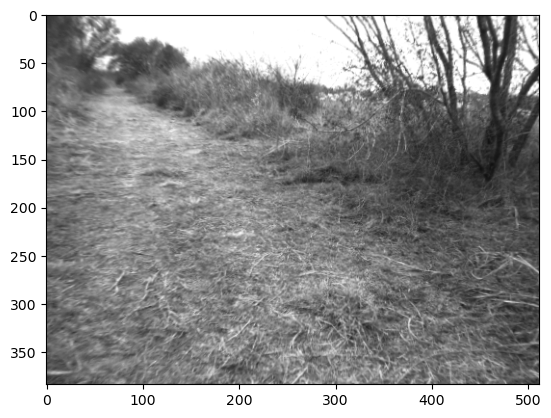

In [6]:
import PIL.ImageOps
grayscale_image = PIL.ImageOps.grayscale(lagr_image)
plt.imshow(grayscale_image, cmap="gray");


We will be using the `pytorch` library below, which operates on *tensors*, which are basically equivalent to multidimensional numpy arrays. It is easy to convert from numpy to pytorch tensors:

In [7]:
grayscale = torch.from_numpy(np.asarray(grayscale_image, dtype=float))
print(f"type={type(grayscale)}, dtype={grayscale.dtype}, shape={grayscale.shape}")


type=<class 'torch.Tensor'>, dtype=torch.float64, shape=torch.Size([384, 512])


Below we first motivate filtering using an edge detection example, explain it in 1D, and then generalize to arbitrary filters.

A frequent operation in computer vision is **edge detection**, which is to find transitions between dark and light areas, or vice versa. A simple edge detector can be implemented using a linear "filtering" operation.  We first show the code below and then explain it in depth:

In [8]:
sobel_u = torch.tensor([[-1, 0, 1]], dtype=float)
I_u = diffdrive.conv2(grayscale, sobel_u)


Above the first line creates a "filter" of size $1 \times 3$, with values $\begin{bmatrix}-1 & 0 & 1\end{bmatrix}$, and then the second line calls a function `conv2` which implements the filtering. The results are shown below:

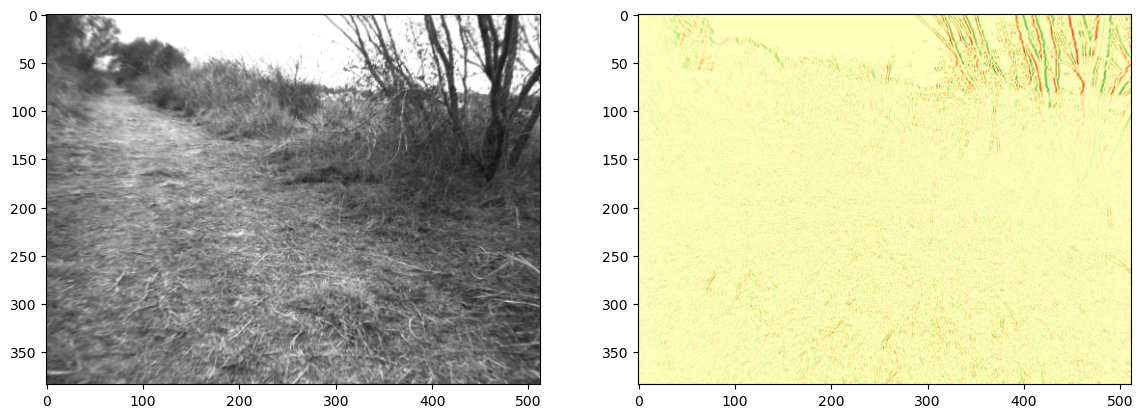

In [9]:
fig, ax = plt.subplot_mosaic([['input', 'edges']], figsize=(14, 7))
ax['input'].imshow(grayscale, cmap="gray")
ax['edges'].imshow(I_u, cmap="RdYlGn");


Above we show the input image and the computed "edge image" side by side. The edge image is color-coded: red is negative, green is positive, and yellow is zero. By comparing with the input, you can see that it highlights strong *vertical edges* in the input image, where green corresponds to dark-light transitions, and red corresponds to light-dark transitions.

## 1D Convolution Example

It is easier to appreciate how this image came to be by showing what is happening on a simpler image.
Consider a simple $1 \times 10$ image consisting of ten pixels.
What happens if we apply the Sobel edge detector to this image?

In [10]:
simple = torch.tensor([[3,3,3,5,5,5,5,2,2,2]], dtype=float)
print(np.vstack([simple.numpy(),
diffdrive.conv2(simple, sobel_u).numpy()]))


[[ 3.  3.  3.  5.  5.  5.  5.  2.  2.  2.]
 [ 3.  0.  2.  2.  0.  0. -3. -3.  0. -2.]]


The first line above shows the pixel values for the original $1 \times 10$ image,
and the second line shows the "edge" image. 
Every value in the edge image is computed from three values in the original image.
For example, the first pixel in the edge image has the value 2, which is calculated from the values 
$\begin{bmatrix}3 & 3 & 5\end{bmatrix}$, as highlighted below:

$$
\begin{bmatrix}
3 & \textbf{3} & \textbf{3} & \textbf{5} & 5 & 5 & 5 & 2 & 2 & 2 \\
3 & 0 & \textbf{2} & 2 & 0 & 0 & -3 & -3 & 0 & -2
\end{bmatrix}
$$

The "recipe" to calculate the edge value is just taking a weighted sum,
where the weights are defined by our filter:

$$
3 \times -1 + 3 \times 0 + 5 \times 1 = 2 = \begin{bmatrix}3 & 3 & 5\end{bmatrix} \begin{bmatrix}-1 & 0 & 1\end{bmatrix}^T
$$

The value $2$ indicates a *positive* edge where the input values go from $3$ to $5$. This operation is then repeated for every output pixel. In other words, every output pixel is computed as the dot product of the filter $\begin{bmatrix}-1 & 0 & 1\end{bmatrix}$ with the *window* of pixels in the input image, centered around the location of the output pixel.

For the simple 1D example above, we could write this with the simple formula

$$
h[i] = \sum_{k=-1}^1 g[k] f[i+k]
$$

where $f$ is the 1D input image, $g$ is the 1D filter or *kernel*, and $h$ is the output edge image. Note that we index into the kernel $g$ with coordinates $k\in[-1,0,1]$. By adding $k$ to the output coordinate $i$, we automatically take the weighted sum of pixels in the input image $f$ centered around $i$.

Let us examine the input and output again:

$$
\begin{bmatrix}
3 & 3 & 3 & 5 & 5 & 5 & 5 & 2 & 2 & 2 \\
3 & 0 & 2 & 2 & 0 & 0 & -3 & -3 & 0 & -2
\end{bmatrix}
$$

We already understand the first $2$. The output pixel next to it *also* has the value $2$, as you can verify using the formula. You might object to the fact that the edge seems to be "doubly wide", and that we could do better with the simpler filter $\begin{bmatrix}-1 & 1\end{bmatrix}$, which people also use. However, making a $1\times 3$ filter with a zero in the middle ensures that the edges do not "shift". The resulting simple filter is widely used and known a **Sobel filter**.

We can now look at the remaining values. It is easy to verify that the $-3$ values result from the negative edge transition from $5$ to $2$ in the image. Also, where the input image is *constant*, the edge output image has a zero, which is great! 

However, we need to make a decision about the output array size and padding. Indeed, what is less obvious are the $3$ and $-2$ values at the beginning and end of the output array. The answer is that here we used *zero-padding*: note that the calculation of the output $h[0]$ requires access to input values $f[-1]$, $f[0]$, and $f[1]$. This is problematic, because $f[-1]$ is *out of bounds*. Zero-padding is the convention to use a zero for every value that is out of bounds for the input. Another way to deal with this issue is to calculate a smaller output image that will only require access to valid input values. Many other strategies can be employed but "zero padding" and "valid" output image size are the two most common ones.

**Correlation vs. Convolution**: we use the term convolution above, but the formula above is really *correlation*. The correct formula for *convolution*, a term from the signal processing literature, is 

$$
h[i] = \sum_{k=-1}^1 g[k] f[i-k]
$$

with the only difference being the minus sign. With the advent of convolutional neural networks (CNNs), 
which we will see below, everyone is now using the term *convolution* even when strictly speaking we mean *correlation*. The justification is that when the kernel is *learned*, the distinction stops mattering, which is actually true: you can just flip the kernel and get the same output as convolution would give you. However, hardcore signal and image processing experts still bristle at this.

## Arbitrary 2D convolutions

> Extending the concept of convolution to 2D.

The 1D definition of convolution above can be easily extended to 2D images and 2D filters:

$$
h[i,j] = \sum_{k, l} g[k,l] f[i+k, j+l]
$$

where $k$ and $l$ range over the two kernel dimensions.
For example, if we applied our 1D filter above to a 2D image,
we would have $k \in \{ 0 \}$ and $l \in \{ -1, 0 1 \}$,
which would apply the filter along individual rows of the image.

Armed with this formula, we can now understand the edge detection above. For each output pixel $h[i,j]$, we do a pointwise multiplication of the $1 \times 3$ filter 

$$\begin{pmatrix}g[0,-1] & g[0,0] & g[0,1]\end{pmatrix} = \begin{pmatrix}-1 & 0 & 1\end{pmatrix}$$

with the $1 \times 3$ window 

$$\begin{pmatrix}f[i,j-1] & f[i,j+0] & f[i,j+1]\end{pmatrix}$$

in the input image $f$.

We can use a different filter to detect horizontal edges. Indeed, the **Horizontal Sobel edge detector** is simply the $3 \times 1$ equivalent, with

$$
g = \begin{pmatrix}-1 \\ 0 \\ 1\end{pmatrix}
$$

The code below applies the horizontal Sobel edge detector to our original image from above.

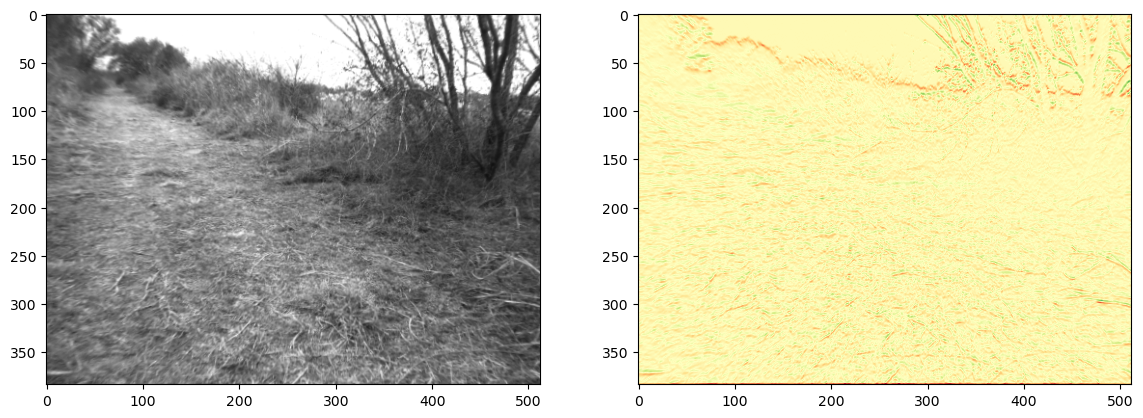

In [11]:
sobel_v = torch.tensor([[-1], [0], [1]], dtype=float)
I_v = diffdrive.conv2(grayscale, sobel_v)
fig, ax = plt.subplot_mosaic([['input', 'edges']], figsize=(14, 7))
ax['input'].imshow(grayscale, cmap="gray")
ax['edges'].imshow(I_v, cmap="RdYlGn");


Note that above we defined the filter such that a positive transition is defined as having dark then light for an increasing value of the *row* coordinate. This explains why above the strong edge with the sky shows up as *negative*, perhaps counter to your intuition.

## Gradients vs. Edges

> In fact, the Sobel operator is a gradient operator, not an edge detector.

Actually, above we told a small white lie: the Sobel filters actually approximate the image *gradient*, i.e., the spatial derivatives of the image values in the horizontal or vertical directions. We associate high gradient values with edges, but actually the two concepts are not the same: saying that there is an edge in the image can be regarded as a binary classification decision: either there is one, or not.
Could we use our Sobel gradient operators to construct an edge detector?

The gradient magnitude (i.e., the Euclidean norm of the gradient) is a positive number that combines both horizontal and vertical gradient values. We can calculate and visualize it as follows:

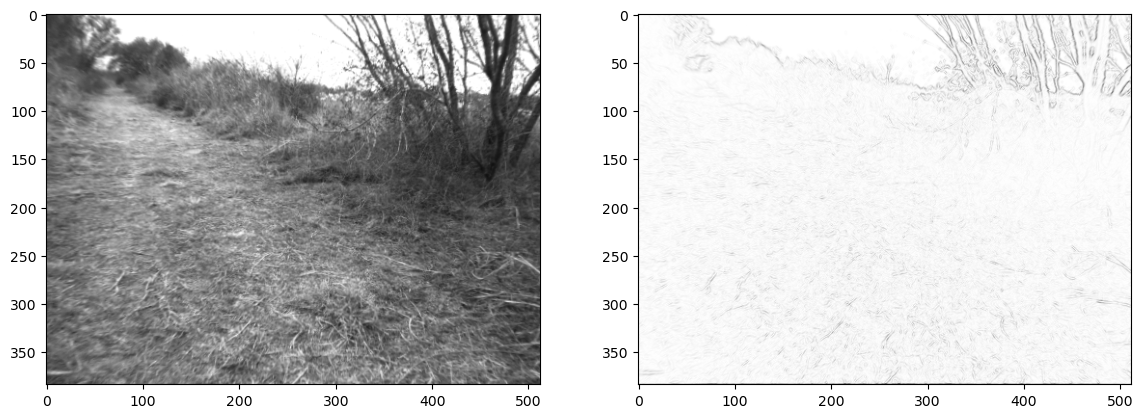

In [12]:
I_m = torch.sqrt(torch.square(I_u)+torch.square(I_v))
fig, ax = plt.subplot_mosaic([['input', 'edges']], figsize=(14, 7))
ax['input'].imshow(grayscale, cmap="gray")
ax['edges'].imshow(I_m, cmap="Greys");


Above, it seems that edges have a high magnitude, and non-edges have a low magnitude, so a very simple idea is to simply threshold and get a *binary edge image*:

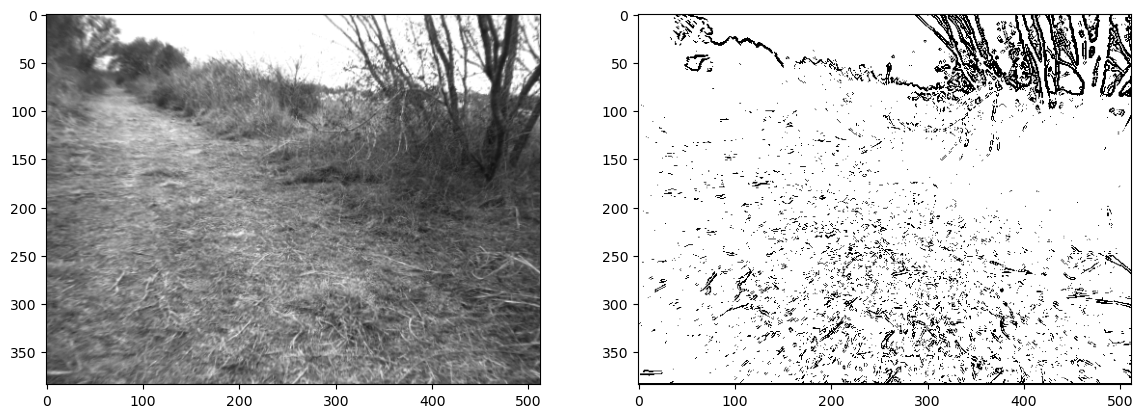

In [13]:
edges = torch.threshold(I_m,50,0)>0
fig, ax = plt.subplot_mosaic([['input', 'edges']], figsize=(14, 7))
ax['input'].imshow(grayscale, cmap="gray")
ax['edges'].imshow(edges, cmap="Greys");


In the above we used a threshold $\theta=50$, but feel free to play with this threshold a bit and see what you like best. You can see that it is not so easy to make this simple, hand-designed edge detector to do what we *really* want, which is to detect edges as we think of them, and not react to all the noise in the image. Image processing, and computer vision in general, is messy and hard!

## Fully Connected Neural Networks

> Convolution can be used to implement neural networks.

Above we looked at edge detection as a classification problem. Our solution was to calculate the output of two different filters (both Sobel operators), combine these with a non-linear operation (the norm), and then apply a threshold at some hand-tuned level. It is only natural to ask whether this idea of taking a linear combination of pixels and feeding it into some "decision maker" could solve other tasks, including the a main goal of computer vision, detecting and recognizing objects, a capability which seems effortless to people yet which eluded computer vision researchers for a long time.

Inspired by the way neurons in the brain appear to be connected, **Neural Networks** were first proposed by [Frank Rosenblatt](https://en.wikipedia.org/wiki/Frank_Rosenblatt) in the 50s, who with his collaborators proposed the **Perceptron**. The mathematical equation for a perceptron is simple:

$$
f(x) = \theta \begin{pmatrix}\sum_k w[k] x[k] + b\end{pmatrix} = \theta(w \cdot x + b)
$$

Here, $w \in \mathbb{R}^n$ is the 1D vector of weights and $x \in \mathbb{R}^n$ is the 1D input signal.
The output $f(x) \in \mathbb{R} $ of the network is obtained by pointwise multiplying the input signal $x$ and the weights $w$, and thresholding.
Here, $\theta :\mathbb{R} \rightarrow \{0,1\} $ denotes the thresholding operation:

$$
\theta(x) \doteq 1 \text{  if  } (x>0) \text{  else  } 0
$$

The scalar quantity $b$ is known as the bias, and can be seen as shifting the decision boundary to values different from $0$.

While a perceptron computes a single output $f(x)$ from the input signal $x$, there are two ways to extend the concept: going *wide* and going *deep*. First, we can extend the concept of the perceptron to be multi-output, yielding $n_o$ **output features**:

$$
f_o(x) = \theta \begin{pmatrix}\sum_k W[o,k] x[k] + b[o]\end{pmatrix} 
$$

We can stack the $n_o$ equations to build a single matrix equation for the multi-output case:

$$
f(x) =
\begin{bmatrix}
f_1(x) \\ \vdots \\ f_{n_o}(x)
\end{bmatrix}
=
\begin{bmatrix}
\sum_k W[1,k] x[k] + b[1] \\
\vdots\\
\sum_k W[n_o,k] x[k] + b[n_o]\\
\end{bmatrix}
=
\theta(W x + b)
$$

where now $W$ is an $n_o \times n$ matrix, and $b$ is a vector of dimension $n_o$. 
The threshold function $\theta: \mathbb{R}^{n_o} \rightarrow \{0,1\}^{n_o}$
applies a threshold operation to each entry of a vector (merely a vector version of the threshold
operation above).
This is called going "wide" as we now create multi-dimensional outputs.

Going *deep* is taking the output from one (multi-dimensional) perceptron and feeding it into a subsequent perceptron.
We call each stage a "layer" in the neural network. 
Multi-layer perceptrons or MLPs can capture increasingly complex concepts present in the input signal. 
The idea is that the output of the first layer learns simpler concepts from the input signal, and the next layer combines these concepts into more complex concepts

The notion of "simple concepts" computed at each layer is very useful, and we have already introduced the term *feature* above to denote these concepts. A feature can be hand-designed, much like the output of the Sobel operator we introduced above, or *learned*. While we will postpone the discussion of *how* to learn these features from data until section 5.6, it is important to know that almost all successful vision pipelines these days learn the feature representations from data, and which features are learned very heavily depends on the task.

The MLP architecture is very powerful, but it is also *very* expensive. For every MLP layer with $n$ input features and $n_o$, we need a *weight matrix* $W$ of size $n_o \times n$. That seems doable in the 1D case, but when thinking about images this becomes rather expensive. Even for relatively low-resolution images, say $256\times 256$, the number of input features $n =256^2=65,536$. Even if we wanted to only compute a relatively modest number of features, say $32$, that still requires over $2$ million weights to be specified. However, even if we had infinite compute and storage, there is another issue with having that many weights when they are to be learned: there might simply not be enough *data* to nail down the weights in a principled manner. 

For computer vision applications, a different class of neural networks called
**convolutional neural networks** alleviates both concerns
by combining notions of multi-layer networks with the earlier introduced concept of convolutions.

## Convolutional Neural Networks

> Convolve, "threshold", repeat...

Three separate ideas gave rise to **Convolutional Neural Networks** or CNNs, which replace fully connected or *dense* layers with *convolutional* layers:

- Linear filtering: Convolution and correlation, and linear filtering in general, are primordial concepts from signal and image processing where they have proved immensely useful.
- Shared weights: The idea to replace a very large weight matrix $W$ with a much smaller $kernel$, which we will denote by $g$, was attractive from a computational resources point of view.
- Translation invariance: Intuitively, a useful feature at one location in the image (or 1D signal) should also be useful at another location. 

The concept of translation invariance is important,
and warrants some more explanation. 
Suppose we apply kernel $g$ to input $x$ to obtain the output $f$.
Translation invariance implies that if we shift the input by $t$, the resulting output
will merely be the original $f$ also shifted by $t$.
Formally, in 1D we write this condition as

$$
f[i+t] = \sum_{k=-1}^1 g[k] x[i+t+k],
$$

i.e., if we *translate* the input signal $x$ by $t$, the output signal $f$ is identical but translated by the same amount. A similar definition holds for 2D translation in the case of 2D convolution.

### Going Wide in CNNs

As with fully connected neural networks, we can go wide with multi-layer CNNs.
For **convolutional layer** $l$, denote the number of input channels by $n_{l,i}$ and the number
of output channels by $n_{l,o}$.
The $o^{th}$ output of layer $l$ is obtained by convolution of its input with the
kernel for output $o$ of layer $l$:

$$
f_{l,o}(x) = \sum_{ k} g[l, o, k] x[l, k] + b[l, o]
$$

In CNNs, each layer also has one bias value $b[o]$ per output channel, as indicated above.

### Going Deep in CNNS

To go *deep*, we specify a nonlinear operation or **activation function** that is applied after the linear convolution step. 
This activation function plays the role of $\theta$ in our fully connected networks above.
Indeed, *without* an activation function, it makes little sense to have two successive linear layers with weights $A$ and $B$: one could just as easily replace them with a *single* linear layer with weights $W = A B$. In addition, from the multi-layer perceptron work we know that the *threshold* operation is a crucial step in *activating* a feature, i.e., deciding when a feature is really present or whether the generated signal is just due to noise. Think back to our primitive edge detector above as well: both the thresholding and the threshold value (which in a perceptron is encoded in a bias $b$) are important for the final result.

The most important activation functions are the sigmoid and "ReLU". We have already encountered the threshold function $\theta$, but historically a "soft threshold" function called the **sigmoid function** was, and still is, very popular:

$$\sigma(x) \doteq \frac{1}{1+\exp(-x)}.$$

Many other activation functions have been proposed since, but it is now widely accepted that the exact shape of the function matters less than the simple fact of having *some* non-linearity. One of the simplest and most popular activation functions just zeroes out any negative values, but otherwise leaves the input signal untouched. This is called the **rectified linear unit**, abbreviated ReLU, and is given by this simple formula:

$$ReLU(x) \doteq \max(0,x).$$

### Pooling Layers

Finally, CNNs also frequently have **pooling layers**. A downside of a convolutional layer is that each output layer is as large as the previous one: the convolution, even when in `valid` mode, only slightly reduces the image size, and not at all when using `same` mode with zero-padding. So called *pooling* layers were again inspired by the human visual system, where an experimentalists observed that while early processing layers where "retinotopic", i.e., had a one-to-one mapping to locations on the imaging surface, successive layers gradually became coarser *and* activated by wider "receptive fields", defined as the area on the retina that were able to influence the activation of a neuron at a given processing stage. There are also computational reasons to wanting to "downscale" the resolution in deeper layers, as many neural net architectures increase the number of features with depth, and hence reducing the resolution correspondingly yielded in approximately the same amount of computation per layer.

Formally, a pooling layer is most often an averaging or maximization operation over an input window of a given size. For example, a "max-pooling" layer in 2D implements the following equation,

$$
h[c, i, j] = \max_{k, l} f[c, i+k, j+l],
$$

where $c\in[n_c]$ ranges over the $n_c$ channels, and once again $k \in [H_k]$ and $l \in [W_k]$. The max operation actually *does* not reduce the resolution by itself: that is done by only computing the pooling output at a certain *stride* $s$, where often the stride is equal to the size of the window. Formally, we have

$$
h[c, i, j] = \max_{k, l} f[c, i s_i + k, j s_j + l],
$$

where the strides $s_i$ and $s_j$ for the row and column indexing can be different. More often than not, however, practitioners choose $s_i=s_j=W_k=H_k$, i.e., square pooling windows with the same stride, e.g., max pooling over $2\times 2$ windows with a stride of $2$. Average and sum-pooling are similarly defined, and are equivalent up to a constant scaling factor.


## A CNN Example: LeNet-5

> A historically important example.

Convolutional neural networks were pioneered by [Kunihiko Fukushima](https://en.wikipedia.org/wiki/Kunihiko_Fukushima) in the 70s, and and [Yann LeCun](https://en.wikipedia.org/wiki/Yann_LeCun) in the 80s. The latter created several CNN-style neural networks for the task of handwritten digit recognition, motivated by an application for the US Postal Service. This work took part from the late 80s to well into the 90s, and is described in a [highly cited 1998 overview paper](https://ieeexplore.ieee.org/abstract/document/726791). Below we show the architecture of LeNet-5 described in that paper.

LeNet-5 takes a single-channel, $32\times 32$ grayscale image as input, and has the following layers:
- 6-channel, $28\times 28$ convolutional layer with $5\times 5$ kernel;
- 6-channel $14\times 14$ pooling layer with stride 2, i.e., sub-sampling to half-resolution;
- 16-channel, $10\times 10$ convolutional layer with $5\times 5$ kernel;
- 16-channel $5\times 5$ pooling layer with stride 2, i.e., sub-sampling once again by half;
- 120-channel fully connected layer;
- 84-unit fully connected layer;
- 10-unit fully connected output layer, i.e., one output unit for every possible digit from 0..9.

Note that above we have not given all the implementation details specific to LeNet-5, only the broad architecture, because there are quite a few quirks in actual implementation that are no longer very relevant today, and hence we omit those details here. 

An instance of this network was able to achieve 0.8% error rate on a standard OCR dataset called [MNIST](https://en.wikipedia.org/wiki/MNIST_database).
You can see an animation of it [here](http://yann.lecun.com/exdb/lenet/).
The MNIST task is now considered solved, and LeNet-5 is not even the best performer anymore, but the network is a great example of the seminal work on CNNs that ultimately led to the latest deep learning revolution.

LeNet-5 it is an example of a very typical architecture that is still used by many modern methods: a sequence of convolutional and pooling layers, progressively increasing the feature-channel count as we go deeper while at the same time decreasing the feature map resolution, until the point where a few fully connected layers are used to perform a final classification decision.

## Semantic Segmentation

> What can neural networks do for robots?

In section 5.6 we will see some other applications, but a very relevant task for robotics is **semantic segmentation**. In this task, every pixel in the image is classified into a finite set of *classes*, such as road, vegetation, building, sky, etc. Think back to the trash sorting robot's need to classify pieces of trash into different categories. Semantic segmentation is similar, but we now do this for *every pixel* in the image. This is a very useful capability for a *mobile* robot, e.g., it can help plan a path over drivable surfaces.

Below we give a pytorch example running a pre-trained semantic segmentation neural network. We can load it from the [Pytorch Hub](https://pytorch.org/hub/), a repository of state of the art neural network models:

In [14]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True);
model.to(DEVICE) # DEVICE will be equal to 'cuda' if GPU is available
model.eval();


Using cache found in /Users/dellaert/.cache/torch/hub/pytorch_vision_v0.10.0


We load a highway driving example to test it:

resolution = 1282x962


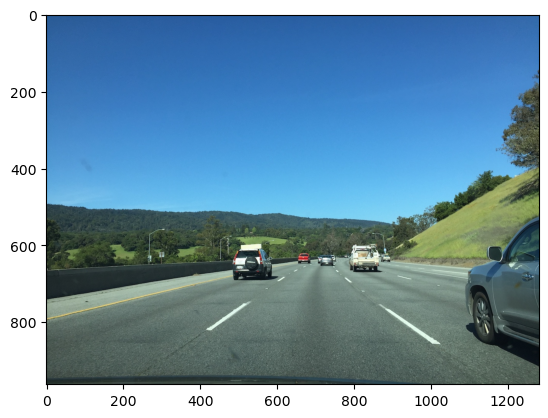

In [15]:
image_name = "highway280.jpg"
highway_image = diffdrive.read_image(image_name)
print(f"resolution = {highway_image.width}x{highway_image.height}")
highway_image = highway_image.convert("RGB")
plt.imshow(highway_image);


We then run the model, after first transforming the image to match the way it was presented to the network during training (which we glean from the PyTorch Hub examples for this model):

In [16]:
# sample execution (requires torchvision)
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(highway_image)
input_batch = input_tensor.unsqueeze(0) # create mini-batch as expected by the model
input_batch = input_batch.to(DEVICE)

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)


Again, we use example code from PyTorch Hub to display the result as a color-coded per-pixel segmentation image. Note the method calls `.cpu()` and `.numpy()` which respectively transfer a PyTorch tensor to the CPU (if it's not already there) and then convert the tensor to a `numpy` array, to play nicely with `matplotlib`:

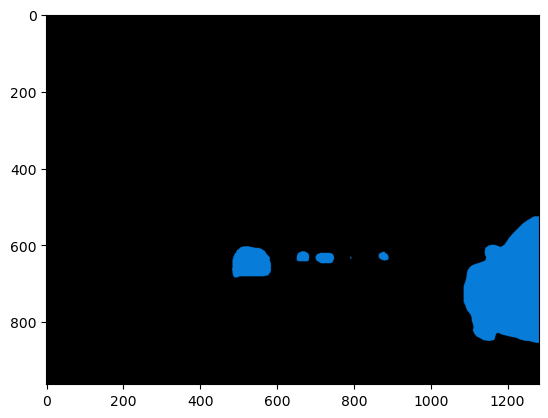

In [17]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = PIL.Image.fromarray(output_predictions.byte().cpu().numpy()).resize(highway_image.size)
r.putpalette(colors)

import matplotlib.pyplot as plt
plt.imshow(r);


## Single Image Depth

>Deep neural networks can infer depth even from a single image.

Below we give a pytorch example running a pre-trained single image depth neural network. Again we read it from the PyTorch Hub, using the MiDaS model trained by Intel researchers:

In [18]:
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type, verbose=False);
midas.to(DEVICE);
midas.eval();


Loading weights:  None


Using cache found in /Users/dellaert/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


This time we manually transform the image:

In [19]:
resized = highway_image.resize((256,256))
normalized = (np.asarray(resized)-[0.485, 0.456, 0.406])/[0.229, 0.224, 0.225]
transposed = np.transpose(normalized, (2, 0, 1))
image32 = np.ascontiguousarray(transposed).astype(np.float32)
input_batch = torch.from_numpy(np.expand_dims(image32,axis=0))


After evaluating the network, we show the result using matplotlib:

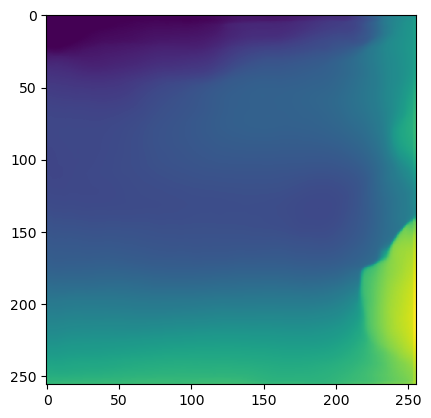

In [20]:
with torch.no_grad():
    prediction = midas(input_batch)

output = prediction.cpu().squeeze().numpy()
plt.imshow(output);
